# A harmonized Landsat Sentinel-2 (HLS) dataset for benchmarking time series reconstruction methods of vegetation indices

In [1]:
skmap_path = './scikit-map'
fairly_path = './fairly'
import numpy as np
import matplotlib.pyplot as plt
import time, os, sys, git, shutil
if os.path.exists(skmap_path):
    shutil.rmtree(skmap_path)
if os.path.exists(fairly_path):
    shutil.rmtree(fairly_path)
git.Repo.clone_from('https://github.com/scikit-map/scikit-map.git', skmap_path, branch='feature_dconsoli')
git.Repo.clone_from('https://github.com/d-consoli/fairly.git', fairly_path)
from pathlib import Path
sys.path.append('')
sys.path.append(skmap_path)
sys.path.append(fairly_path+'/src')
import seasconv
import fast_hants
import fairly
from skmap.io.transform import fill
from skmap.io import RasterData
from skmap.plotter import plot_rasters

In [8]:
skmap_path = './scikit-map'
fairly_path = './fairly'
import numpy as np
import matplotlib.pyplot as plt
import time, os, sys, git, shutil
from pathlib import Path
sys.path.append('')
sys.path.append(skmap_path)
sys.path.append(fairly_path+'/src')
import seasconv
import fast_hants
import fairly
from skmap.io.transform import fill
from skmap.io import RasterData
from skmap.plotter import plot_rasters

## Download the files from Zenodo

In [ ]:
data_path = './data'
if os.path.exists(data_path):
    shutil.rmtree(data_path)
zenodo = fairly.client(id="zenodo")
dataset = zenodo.get_dataset("https://zenodo.org/record/8119407")
dataset.store(data_path, random_sleep=0.15)

## Compute methods performance on benchmark dataset

Tiles: ['T22LEH', 'T32QPK', 'T31UFS', 'T45WWM', 'T19FCV', 'T49MFV']

In [2]:
def compute_rmse_nrmse(data_ref, data_rec, mask):
    diff = np.array(data_ref[mask] - data_rec[mask], dtype=np.double)
    RMSE = np.sqrt(np.nanmean((diff) ** 2))
    mean_ref = np.nanmean(np.array(data_ref[mask], dtype=np.double))
    NRMSE = RMSE / np.abs(mean_ref)
    return RMSE, NRMSE, mean_ref

In [3]:
# Parameters
n_ipy = 23 # 16-days images (23 images per year)
tiles = ('T22LEH', 'T32QPK', 'T31UFS', 'T45WWM', 'T19FCV', 'T49MFV')
n_t = len(tiles)
n_jobs = 40
date_step = ([16] * 22) + [13]
try:
    import mkl
    mkl.set_num_threads(n_jobs)
except:
    pass
# Naming detatils:
# RMSE: root mean square error on artificial gaps
# NRMSE: RMSE normalized by the absolute values of the mean
# pct: percentage of filled artificial gaps
# pt/g: per tile/global
# f/i: filled by the method/interception of all methods
# time: total computational time per tile

# Select other gap-filling methods for the comparison
include_HANTS = False

# Initialize variables to store per-tile results
RMSE_pt_i_SeasConv = np.zeros(n_t)
NRMSE_pt_i_SeasConv = np.zeros(n_t)
mean_ref_i_SeasConv = np.zeros(n_t)
RMSE_pt_f_SeasConv = np.zeros(n_t)
NRMSE_pt_f_SeasConv = np.zeros(n_t)
mean_ref_f_SeasConv = np.zeros(n_t)
pct_pt_f_SeasConv = np.zeros(n_t)
time_SeasConv = np.zeros(n_t)
n_elements_pt_i_SeasConv = np.zeros(n_t)
n_elements_pt_f_SeasConv = np.zeros(n_t)

if include_HANTS:
    RMSE_pt_i_HANTS = np.zeros(n_t)
    NRMSE_pt_i_HANTS = np.zeros(n_t)
    mean_ref_i_HANTS = np.zeros(n_t)
    RMSE_pt_f_HANTS = np.zeros(n_t)
    NRMSE_pt_f_HANTS = np.zeros(n_t)
    mean_ref_f_HANTS = np.zeros(n_t)
    pct_pt_f_HANTS = np.zeros(n_t)
    time_HANTS = np.zeros(n_t)
    n_elements_pt_i_HANTS = np.zeros(n_t)
    n_elements_pt_f_HANTS = np.zeros(n_t)


for i, tile in enumerate(tiles):
    print(f'Tile number {i+1}/{len(tiles)}: {tile}')
    # Read the reference data
    raser_data_ref = RasterData(
        'data/HLS.'+tile+'.{dt}.v2.0.NDVI.tif', verbose=True
        ).timespan('2015001', '2022365', 'days', date_step, date_format="%Y%j", ignore_29feb=True, date_style='start_date'
        ).read(n_jobs=n_jobs)
    data_ref = raser_data_ref.array
    raser_data_gap = RasterData(
        'data/HLS.'+tile+'.{dt}.v2.0.NDVI_art_gaps.tif', verbose=True
        ).timespan('2015001', '2022365', 'days', date_step, date_format="%Y%j", ignore_29feb=True, date_style='start_date'
        ).read(n_jobs=n_jobs)
    data_gap = raser_data_gap.array

    # Get the indices of the artificial gaps
    mask_ref = np.isnan(data_ref)
    mask_gap = np.isnan(data_gap)
    mask_art_gap = mask_gap & ~mask_ref
    n_art_gap = np.sum(mask_art_gap)

    # SeasConv
    print("--- Filling with SeasConv")
    start_time = time.time()
    raser_data_gap.transform(fill.SeasConv(season_size=n_ipy, att_env=10, att_seas=60, n_jobs=n_jobs), inplace=False, outname = None)
    time_SeasConv[i] = time.time() - start_time
    print(f"------ Total time {time_SeasConv[i]:.2f} s")
    df_SeasConv = raser_data_gap.info.query(f'{raser_data_gap.NAME_COL}.str.contains("seas.conv")')
    data_SeasConv = raser_data_gap.array[:,:,df_SeasConv[~df_SeasConv["name"].str.contains("qa")].index]
    mask_fill_art_gap_SeasConv = mask_art_gap & ~np.isnan(data_SeasConv)
    pct_pt_f_SeasConv[i] = np.sum(mask_fill_art_gap_SeasConv) / n_art_gap
    RMSE_pt_f_SeasConv[i], NRMSE_pt_f_SeasConv[i], mean_ref_f_SeasConv[i] = compute_rmse_nrmse(data_ref, data_SeasConv, mask_fill_art_gap_SeasConv)
    n_elements_pt_f_SeasConv[i] = np.sum(mask_fill_art_gap_SeasConv)

    # HANTS
    if include_HANTS:
        print("--- Filling with HANTS")
        start_time = time.time()
        hgf = fast_hants.FastHANTS(ts=data_gap, n_ipy=n_ipy, n_freq=3, reg_param=0.05, min_ipy_pct=20)
        data_HANTS = hgf.run(), 0, -1
        time_HANTS[i] = time.time() - start_time
        print(f"------ Total time {time_HANTS[i]:.2f} s")
        mask_fill_art_gap_HANTS = mask_art_gap & ~np.isnan(data_HANTS)
        pct_pt_f_HANTS[i] = np.sum(mask_fill_art_gap_HANTS) / n_art_gap
        RMSE_pt_f_HANTS[i], NRMSE_pt_f_HANTS[i], mean_ref_f_HANTS[i] = compute_rmse_nrmse(data_ref, data_HANTS, mask_fill_art_gap_HANTS)
        n_elements_pt_f_HANTS[i] = np.sum(mask_fill_art_gap_HANTS)

    # Interception
    if include_HANTS:
        mask_int = mask_fill_art_gap_SeasConv & mask_fill_art_gap_HANTS
    else:
        mask_int = mask_fill_art_gap_SeasConv        
    RMSE_pt_i_SeasConv[i], NRMSE_pt_i_SeasConv[i], mean_ref_i_SeasConv[i] = compute_rmse_nrmse(data_ref, data_SeasConv, mask_int)
    n_elements_pt_i_SeasConv[i] = np.sum(mask_int)    
    if include_HANTS:
        RMSE_pt_i_HANTS[i], NRMSE_pt_i_HANTS[i], mean_ref_i_HANTS[i] = compute_rmse_nrmse(data_ref, data_HANTS, mask_int)
        n_elements_pt_i_HANTS[i] = np.sum(mask_int)
    

Tile number 1/6: T22LEH
[15:23:44] First temporal raster: data/HLS.T22LEH.2015001.v2.0.NDVI.tif
[15:23:44] Last temporal raster: data/HLS.T22LEH.2022353.v2.0.NDVI.tif
[15:23:44] 184 temporal rasters added 
[15:23:44] RasterData with 184 temporal and 0 static rasters
[15:23:44] Reading 184 raster file(s) using 40 workers
[15:24:47] Read array shape: (3660, 3660, 184)
[15:24:47] First temporal raster: data/HLS.T22LEH.2015001.v2.0.NDVI_art_gaps.tif
[15:24:47] Last temporal raster: data/HLS.T22LEH.2022353.v2.0.NDVI_art_gaps.tif
[15:24:47] 184 temporal rasters added 
[15:24:47] RasterData with 184 temporal and 0 static rasters
[15:24:47] Reading 184 raster file(s) using 40 workers
[15:25:47] Read array shape: (3660, 3660, 184)
--- Filling with SeasConv
[15:26:19] Transforming data using SeasConv on (3660, 3660, 184)
[15:30:24] Tranformer SeasConv execution time: 269.60 segs
------ Total time 295.49 s
Tile number 2/6: T32QPK
[15:32:43] First temporal raster: data/HLS.T32QPK.2015001.v2.0.NDVI

In [4]:
# Compute global RMSE, NRMSE, and percentage filled
total_elements_i_SeasConv = np.sum(n_elements_pt_i_SeasConv)
total_elements_f_SeasConv = np.sum(n_elements_pt_f_SeasConv)
RMSE_g_i_SeasConv = np.sqrt(np.average(RMSE_pt_i_SeasConv ** 2, weights=n_elements_pt_i_SeasConv))
NRMSE_g_i_SeasConv = RMSE_g_i_SeasConv / np.abs(np.average(mean_ref_i_SeasConv, weights=n_elements_pt_i_SeasConv))
RMSE_g_f_SeasConv = np.sqrt(np.average(RMSE_pt_f_SeasConv ** 2, weights=n_elements_pt_f_SeasConv))
NRMSE_g_f_SeasConv = RMSE_g_f_SeasConv / np.abs(np.average(mean_ref_f_SeasConv, weights=n_elements_pt_f_SeasConv))
pct_g_f_SeasConv = np.sum(pct_pt_f_SeasConv * n_elements_pt_f_SeasConv) / total_elements_f_SeasConv

if include_HANTS:
    total_elements_i_HANTS = np.sum(n_elements_pt_i_HANTS)
    total_elements_f_HANTS = np.sum(n_elements_pt_f_HANTS)
    RMSE_g_i_HANTS = np.sqrt(np.average(RMSE_pt_i_HANTS ** 2, weights=n_elements_pt_i_HANTS))
    NRMSE_g_i_HANTS = RMSE_g_i_HANTS / np.abs(np.average(mean_ref_i_HANTS, weights=n_elements_pt_i_HANTS))
    RMSE_g_f_HANTS = np.sqrt(np.average(RMSE_pt_f_HANTS ** 2, weights=n_elements_pt_f_HANTS))
    NRMSE_g_f_HANTS = RMSE_g_f_HANTS / np.abs(np.average(mean_ref_f_HANTS, weights=n_elements_pt_f_HANTS))
    pct_g_f_HANTS = np.sum(pct_pt_f_HANTS * n_elements_pt_f_HANTS) / total_elements_f_HANTS

In [5]:
print(f'Respective tile name {tiles}')
print('-------------------------------------------------')
print(f'NRMSE per tile on all fake gaps filled by the method:  \n - SeasConv ->')
print(("{:.2f}, " * len(NRMSE_pt_f_SeasConv)).format(*NRMSE_pt_f_SeasConv))
if include_HANTS:
    print(' - HANTS ->')
    print(("{:.2f}, " * len(NRMSE_pt_f_HANTS)).format(*NRMSE_pt_f_HANTS))

print('-------------------------------------------------')
print(f'NRMSE per tile on the intersection of fake gaps filled by all the methods:  \n - SeasConv ->')
print(("{:.2f}, " * len(NRMSE_pt_i_SeasConv)).format(*NRMSE_pt_i_SeasConv))
if include_HANTS:
    print(' - HANTS ->')
    print(("{:.2f}, " * len(NRMSE_pt_i_HANTS)).format(*NRMSE_pt_i_HANTS))

print('-------------------------------------------------')
print(f'Overall NRMSE intersection of fake gaps filled by all the methods:  \n - SeasConv ->')
print(f"{NRMSE_g_i_SeasConv:.2f}, ")
if include_HANTS:
    print(' - HANTS ->')
    print(f"{NRMSE_g_i_HANTS:.2f}")

print('-------------------------------------------------')
print(f'Percentage per tile of fake gaps filled by the method:  \n - SeasConv ->')
print(("{:.2f}, " * len(pct_pt_f_SeasConv)).format(*pct_pt_f_SeasConv))
if include_HANTS:
    print(' - HANTS ->')
    print(("{:.2f}, " * len(pct_pt_f_HANTS)).format(*pct_pt_f_HANTS))

print('-------------------------------------------------')
print(f'Computational time per tile for each method:  \n - SeasConv ->')
print(("{:.2f}, " * len(time_SeasConv)).format(*time_SeasConv))
if include_HANTS:
    print(' - HANTS ->')
    print(("{:.2f}, " * len(time_HANTS)).format(*time_HANTS))


Respective tile name ('T22LEH', 'T32QPK', 'T31UFS', 'T45WWM', 'T19FCV', 'T49MFV')
-------------------------------------------------
NRMSE per tile on all fake gaps filled by the method:  
 - SeasConv ->
0.13, 0.04, 0.52, 0.71, 1.46, 0.08, 
-------------------------------------------------
NRMSE per tile on the intersection of fake gaps filled by all the methods:  
 - SeasConv ->
0.13, 0.04, 0.52, 0.71, 1.46, 0.08, 
-------------------------------------------------
Overall NRMSE intersection of fake gaps filled by all the methods:  
 - SeasConv ->
0.47, 
-------------------------------------------------
Percentage per tile of fake gaps filled by the method:  
 - SeasConv ->
1.00, 1.00, 1.00, 1.00, 0.87, 1.00, 
-------------------------------------------------
Computational time per tile for each method:  
 - SeasConv ->
295.49, 330.28, 312.47, 366.79, 558.31, 626.80, 


## Visual inspection of the time series reconstruction

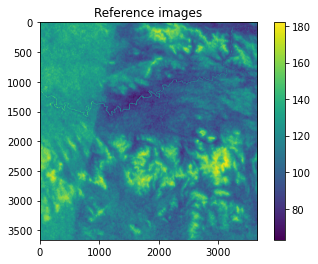

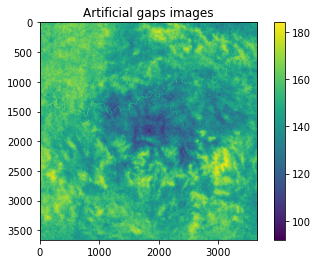

In [6]:
# Distribution of the gaps in the images
plt.imshow(np.sum(mask_ref,axis=2))
plt.colorbar()
plt.title('Reference images')
plt.show()
# Distribution of the gaps in the image
plt.imshow(np.sum(mask_gap,axis=2))
plt.colorbar()
plt.title('Artificial gaps images')
plt.show()

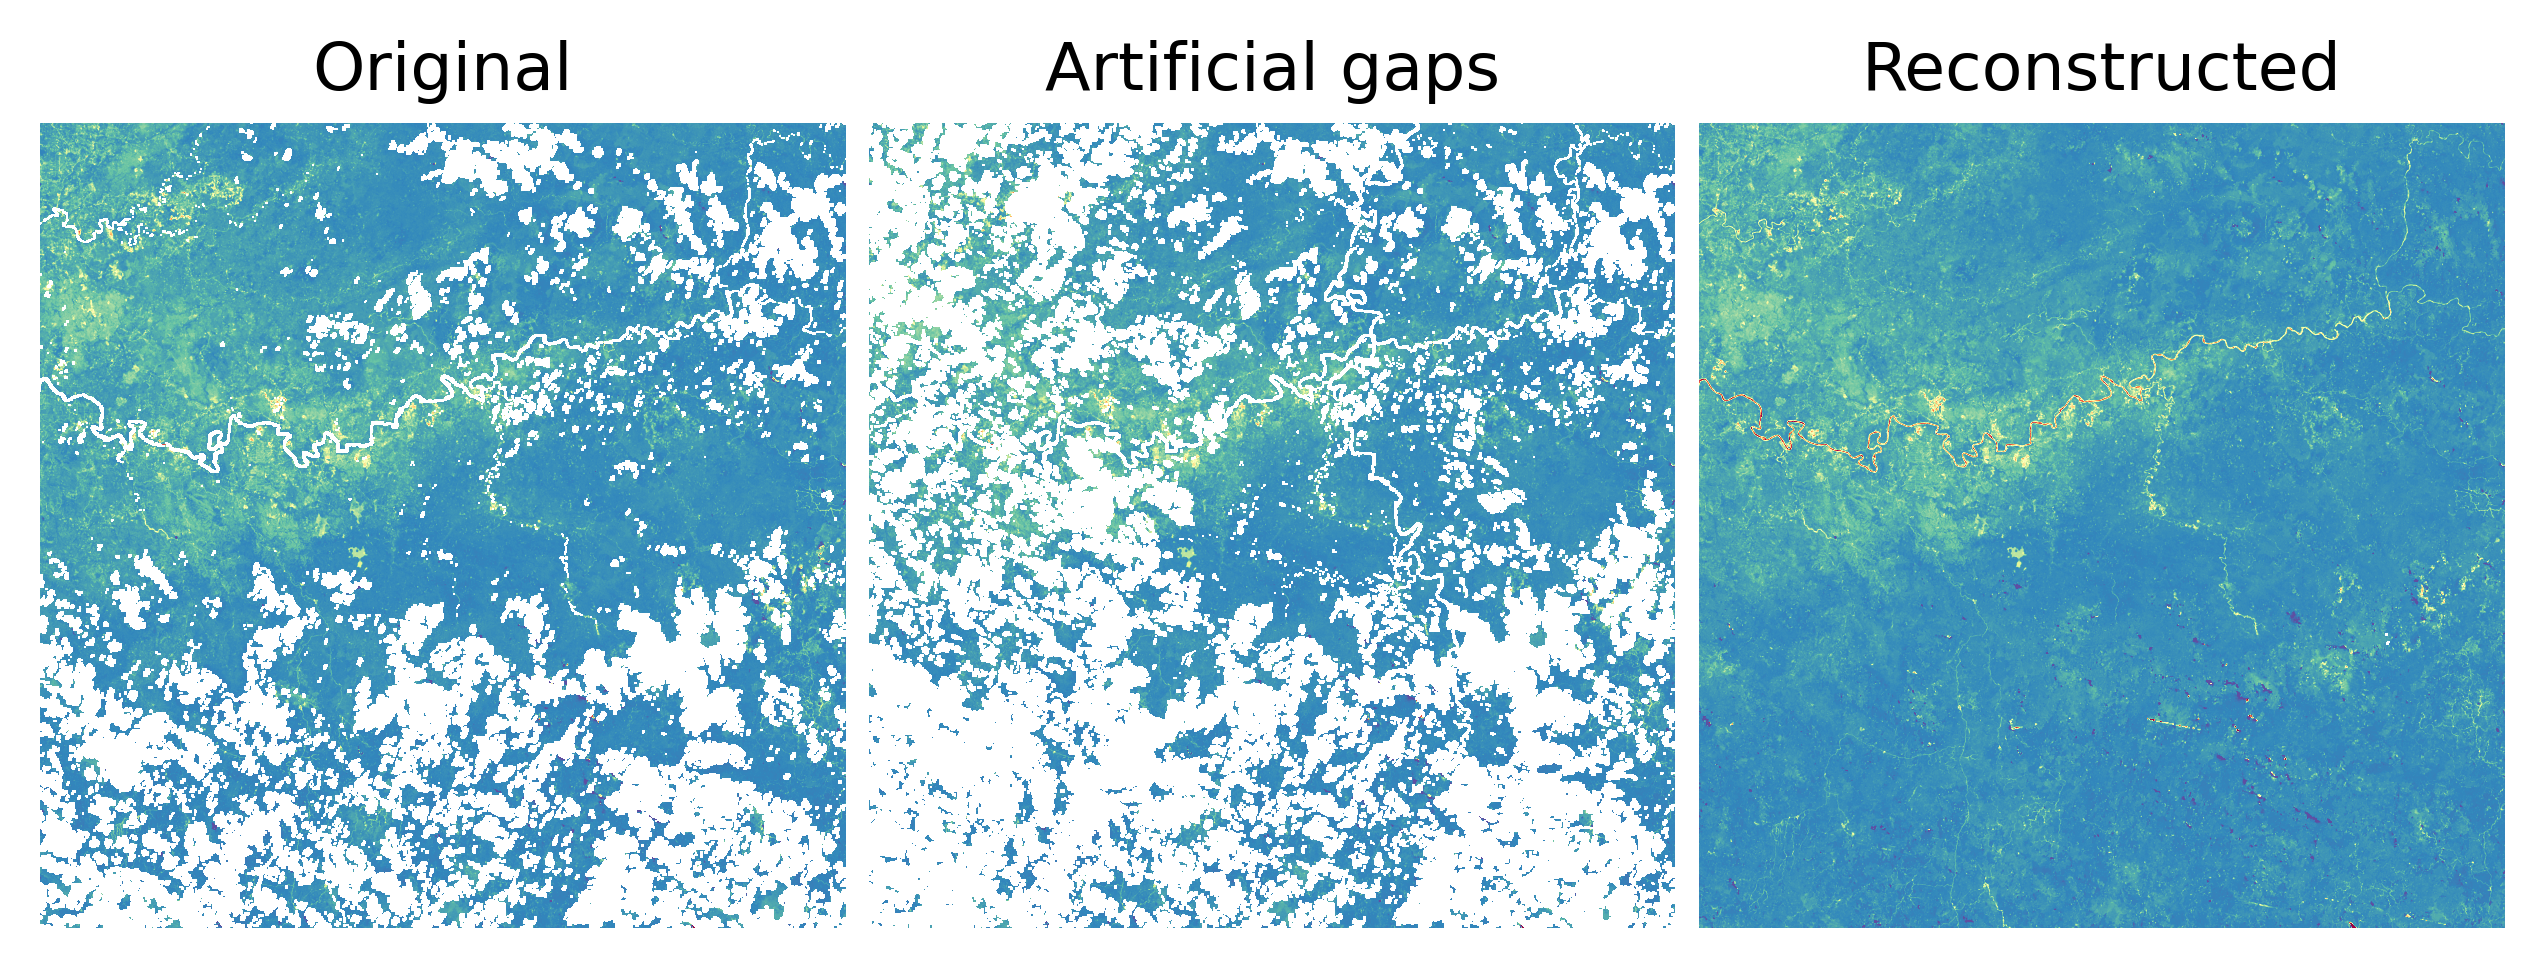

In [9]:
idx = 100
orig_img = data_ref[:,:,idx]
art_gaps_img = data_gap[:,:,idx]
filled_img = data_SeasConv[:,:,idx]
plot_rasters(
    orig_img,
    art_gaps_img,
    filled_img,
    cmaps='Spectral',
    dpi=400,
    vmin=1,
    vmax=10000,
    figsize=8,
    titles=['Original','Artificial gaps', 'Reconstructed'],
    nodata=-32000
)

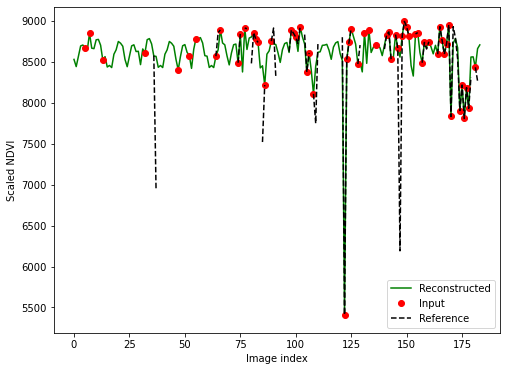

In [10]:
pix_x = 1500
pix_y = 2000
ref_ts = data_ref[pix_x,pix_y,:]
seasconv_ts = data_SeasConv[pix_x,pix_y,:]
gap_ts = data_gap[pix_x,pix_y,:]
idx = slice(0,184)
plt.figure(figsize=(8,6))
plt.plot(seasconv_ts[idx], 'g', label='Reconstructed')
plt.plot(gap_ts[idx], 'ro', label='Input')
plt.plot(ref_ts[idx], 'k--', label='Reference')
plt.legend()
plt.xlabel('Image index')
plt.ylabel('Scaled NDVI')
plt.savefig('gap_filling_ts.png')
plt.show()